In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet
from scipy import stats
import sys
import os
from pykeen.datasets.base import PathDataset
from pykeen.predict import predict_target
from scipy.stats import kstest
import pickle
from scipy.stats import mannwhitneyu, kruskal, pearsonr
from typing import List

sys.path.append(os.path.abspath('../src/'))

from utils import get_predictions_tail, two_group_g2p_ranking_test_hetionet

# Load Data

In [33]:
data = Hetionet(random_state=42)
data.summarize() 

# these are used to know if a triple is in the training, testing or validation set
train_triples = data.training.triples
test_triples = data.testing.triples
valid_triples = data.validation.triples

Reconstructing all label-based triples. This is expensive and rarely needed.


Hetionet (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    45158       24             1800157
Testing     45158       24              225020
Validation  45158       24              225020
Total       -           -              2250197
Head                     Relation    tail
-----------------------  ----------  ------------
Anatomy::UBERON:0000002  AdG         Gene::10005
Anatomy::UBERON:0000002  AdG         Gene::114804
Anatomy::UBERON:0000002  AdG         Gene::118670
Anatomy::UBERON:0000002  AdG         Gene::128989
Anatomy::UBERON:0000002  AdG         Gene::132851



Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [3]:
for x in test_triples:
    if 'DaG' in x:
        print(x)

['Disease::DOID:1909' 'DaG' 'Gene::11186']
['Disease::DOID:1826' 'DaG' 'Gene::7010']
['Disease::DOID:3310' 'DaG' 'Gene::4792']
['Disease::DOID:1324' 'DaG' 'Gene::4838']
['Disease::DOID:9352' 'DaG' 'Gene::4825']
['Disease::DOID:1826' 'DaG' 'Gene::10656']
['Disease::DOID:5041' 'DaG' 'Gene::7171']
['Disease::DOID:1612' 'DaG' 'Gene::5154']
['Disease::DOID:1612' 'DaG' 'Gene::675']
['Disease::DOID:4989' 'DaG' 'Gene::1990']
['Disease::DOID:9744' 'DaG' 'Gene::1234']
['Disease::DOID:10534' 'DaG' 'Gene::4609']
['Disease::DOID:4362' 'DaG' 'Gene::3642']
['Disease::DOID:12306' 'DaG' 'Gene::1493']
['Disease::DOID:10763' 'DaG' 'Gene::3685']
['Disease::DOID:8986' 'DaG' 'Gene::56342']
['Disease::DOID:5419' 'DaG' 'Gene::256021']
['Disease::DOID:3571' 'DaG' 'Gene::192286']
['Disease::DOID:10608' 'DaG' 'Gene::5996']
['Disease::DOID:9352' 'DaG' 'Gene::135154']
['Disease::DOID:1324' 'DaG' 'Gene::5293']
['Disease::DOID:7148' 'DaG' 'Gene::9474']
['Disease::DOID:8893' 'DaG' 'Gene::920']
['Disease::DOID:1909' '

In [4]:
data = Hetionet(random_state=42)
data.summarize()  # Summarize the dataset to ensure it is downloaded
# Load the Hetionet edges as downloaded by the PyKEEN dataloader
df: pd.DataFrame = pd.read_csv(
    "~/.data/pykeen/datasets/hetionet/hetionet-v1.0-edges.sif.gz", sep="\t"
)
# Load these edges into a NX graph and compute the degree for each entity
H: nx.MultiGraph = nx.from_pandas_edgelist(
    df, "source", "target", create_using=nx.MultiGraph()
)
degs: dict = dict(H.degree())

Hetionet (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    45158       24             1800157
Testing     45158       24              225020
Validation  45158       24              225020
Total       -           -              2250197
Head                     Relation    tail
-----------------------  ----------  ------------
Anatomy::UBERON:0000002  AdG         Gene::10005
Anatomy::UBERON:0000002  AdG         Gene::114804
Anatomy::UBERON:0000002  AdG         Gene::118670
Anatomy::UBERON:0000002  AdG         Gene::128989
Anatomy::UBERON:0000002  AdG         Gene::132851



In [5]:
types = set()
for node in H.nodes():
    types.add(':'.join(node.split(":")[:-1]))
    if 'Disease::DOID' in node:
        print(node)
# print(types)



Disease::DOID:986
Disease::DOID:9206
Disease::DOID:5419
Disease::DOID:3083
Disease::DOID:7148
Disease::DOID:14227
Disease::DOID:1793
Disease::DOID:8893
Disease::DOID:2986
Disease::DOID:9008
Disease::DOID:10652
Disease::DOID:7147
Disease::DOID:13223
Disease::DOID:0050741
Disease::DOID:14330
Disease::DOID:7693
Disease::DOID:635
Disease::DOID:0050742
Disease::DOID:3312
Disease::DOID:418
Disease::DOID:11612
Disease::DOID:8577
Disease::DOID:1612
Disease::DOID:332
Disease::DOID:0050156
Disease::DOID:1909
Disease::DOID:263
Disease::DOID:2531
Disease::DOID:2394
Disease::DOID:219
Disease::DOID:9970
Disease::DOID:12365
Disease::DOID:8778
Disease::DOID:1324
Disease::DOID:824
Disease::DOID:2377
Disease::DOID:10283
Disease::DOID:4481
Disease::DOID:10763
Disease::DOID:3393
Disease::DOID:1686
Disease::DOID:9744
Disease::DOID:12849
Disease::DOID:1936
Disease::DOID:2994
Disease::DOID:1319
Disease::DOID:1192
Disease::DOID:13499
Disease::DOID:5559
Disease::DOID:1595
Disease::DOID:1024
Disease::DOID:2596


## Get a list of all genes

In [6]:
genes = set()
for node in H.nodes():
    if node.startswith("Gene"):
        genes.add(node)
genes = list(genes)
genes.sort()
print(len(genes))
    

19145


## Create a mapping from MONDO to DOID

In [7]:
import fastobo #.term.SynonymClause
import networkx as nx

G = nx.MultiDiGraph()
obo = fastobo.load('../mondo.obo')

for frame in obo:
    if isinstance(frame, fastobo.term.TermFrame):
        G.add_node(str(frame.id))
        for clause in frame:
            if isinstance(clause, fastobo.term.SynonymClause):
                str_clause = str(clause)
                if 'EXACT' in str_clause:
                    row = str_clause.split(' EXACT ')[-1]
                    row = row.replace('[', '').replace(']', '')
                    row = row.split(',')
                    for node in row:
                        node = node.strip()
                        # remove all spaces from node
                        node = node.replace(' ', '')
                        node = node.replace('\t', '')
                        if node not in G.nodes():
                            G.add_node(node)
                        G.add_edge(str(frame.id), node)
                
                


In [8]:
mondo_to_doid = {}
for n in G.nodes:
    if n not in mondo_to_doid:
                mondo_to_doid[n] = [] 
    for neighbor in G.neighbors(n):
        if neighbor.startswith('DOID'):
            mondo_to_doid[n].append(neighbor)
print(len(mondo_to_doid))

57221


# Load model

In [9]:
# Load the pretrained model
model = torch.load(
    "../PyKeenOut/rotatE_hetionet/trained_model.pkl",
    map_location=torch.device("cpu"),
)

# Load disease identifiers

In [10]:

def load_ancestry_hpo_file(_f):
    _hpos = []
    for _line in open(_f,'r'):
        _row = _line.strip().split('\t')
        _tmp = _row[-1].split(',')
        _hpos += _tmp
    return list(set(_hpos))

european_terms = load_ancestry_hpo_file('../AncestrySpecificMONDO/all_pathogenic_ancestry_groups__AF_nfe_onf.tsv')
arfican_terms = load_ancestry_hpo_file('../AncestrySpecificMONDO/all_pathogenic_ancestry_groups__AF_afr.tsv')    
latino_terms = load_ancestry_hpo_file('../AncestrySpecificMONDO/all_pathogenic_ancestry_groups__AF_amr.tsv')
east_asian_terms = load_ancestry_hpo_file('../AncestrySpecificMONDO/all_pathogenic_ancestry_groups__AF_eas.tsv')

In [11]:
print('East Asian',len(east_asian_terms))
print('European',len(european_terms))
print('African',len(arfican_terms))
print('Latino',len(latino_terms))

East Asian 459
European 1104
African 427
Latino 624


## Convert MONDO to exact match DOID
I am only using extact matches, none of this partial matching junk

In [12]:
def convert_to_doid(terms,mondo_to_doid):
    doid_terms   = []
    for term in terms:
        if term in mondo_to_doid:
            doid_terms += mondo_to_doid[term]
    doid_terms = [ 'Disease::' + x for x in doid_terms]
    print('OG',len(terms))
    print('DOID',len(doid_terms))
    return doid_terms

east_asian_doid = convert_to_doid(east_asian_terms,mondo_to_doid)
european_doid = convert_to_doid(european_terms,mondo_to_doid)
african_doid = convert_to_doid(arfican_terms,mondo_to_doid)
latino_doid = convert_to_doid(latino_terms,mondo_to_doid)

OG 459
DOID 223
OG 1104
DOID 497
OG 427
DOID 195
OG 624
DOID 309


# Run the experiments

Terms test edges A 269
Loading predictions_df.pkl
       tail_id      score  in_training  in_testing  tail_label entity_type  \
23021    23021 -15.128882        False       False  Gene::3569        Gene   
18816    18816 -15.163717        False       False  Gene::1958        Gene   
24528    24528 -15.175199        False       False  Gene::4609        Gene   
29634    29634 -15.216660        False       False  Gene::7040        Gene   
17955    17955 -15.367072        False       False  Gene::1499        Gene   

      triple_type   deg      rank  
23021       novel   774  1.000000  
18816       novel   899  0.999948  
24528       novel  1342  0.999896  
29634       novel  1188  0.999843  
17955       novel  1333  0.999791  
Terms test edges A 201
Loading predictions_df.pkl
       tail_id      score  in_training  in_testing  tail_label entity_type  \
23021    23021 -15.128882        False       False  Gene::3569        Gene   
18816    18816 -15.163717        False       False  Gene::1

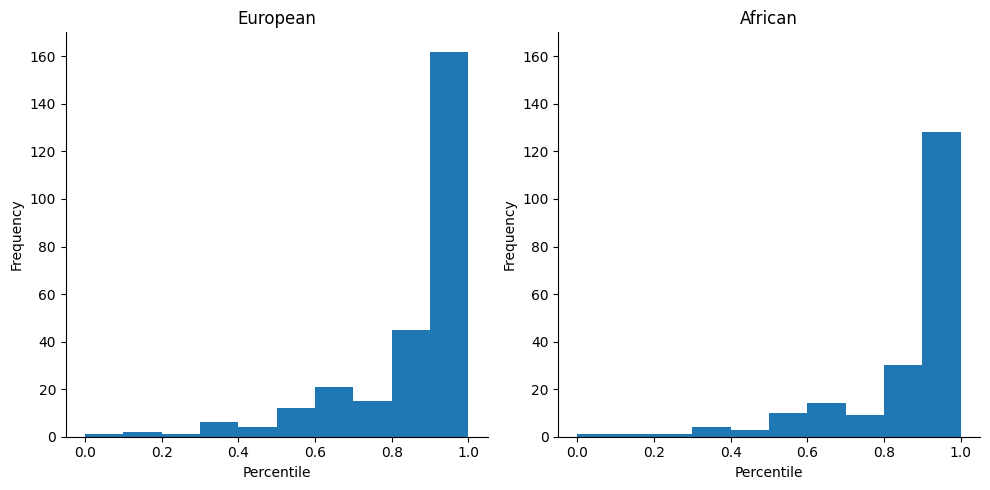

In [60]:
def get_test_edges_for_term(terms,relation,test_triples, progress_bar=False) -> List[List[str]]:
    """
    take a list of terms, relation type and return all edges in the test set that contain the term and relation
    """
    # pre filter test_triples to only have edges that contain the relation, this is a HUGE speed up
    filtered_test_triples = [edge for edge in test_triples if relation in edge]
    terms_test_edges = []
    for i,term in enumerate(terms):
        # print out a progress bar update every 5% complete
        if i % (len(terms) // 20) == 0 and progress_bar:
            print(f'{i} / {len(terms)}')
        # find all edges that contain the term and relation
        terms_test_edges += [edge for edge in filtered_test_triples if term in edge and relation in edge]
            
    # print(edge)
    # print(type(edge))
    # print(edge[0])
    return terms_test_edges

def get_scores_for_edges(terms, relation, model, degs, train_triples,test_triples,validation_triples) -> List[float]:
    """
    Make predictions for each term and return the score percentiles (higher is better) of test edges for each term
    """
    terms_test_edges = get_test_edges_for_term(terms,relation,test_triples, progress_bar=False)
    print('Terms test edges A',len(terms_test_edges))
    # check if predictions_df.pkl exists if it does load it
    if os.path.exists('predictions_df.pkl'):
        print('Loading predictions_df.pkl')
        predictions_df = pickle.load(open('predictions_df.pkl','rb'))
    else:
        pass
        # predictions_df: pd.DataFrame = get_predictions_tail(terms_a_test_edges[0][0], relation, data, model, degs, train_triples, test_triples, validation_triples)
        # pickle.dump(predictions_df,open('predictions_df.pkl','wb'))

    # remove all predictions that are not entity_type Gene
    predictions_df = predictions_df[predictions_df['entity_type'] == 'Gene']
    # sort the predictions by score
    predictions_df = predictions_df.sort_values(by=['score'],ascending=False)
    # assign a percentile to each prediction
    predictions_df['rank'] = predictions_df['score'].rank(pct=True)
    print(predictions_df.head())
    # get the score for each edge in terms_a_test_edges
    scores = []
    for edge in terms_test_edges:
        # get the score for the edge
        score = predictions_df[predictions_df['tail_label'] == edge[2]]['rank'].values[0]
        scores.append(score)
    
    return scores

def plot_two_groups_hists(scores_a, scores_b, label_a, label_b, prefix):
        """
        Plot the scores for two groups as two histograms
        """
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # make bins 0 -  1 in increments of .1
        bins = np.arange(0, 1.1, 0.1)
        axes[0].hist(scores_a,bins=bins)
        axes[0].set_title(label_a)
        axes[0].set_xlabel('Percentile')
        axes[0].set_ylabel('Frequency')
        axes[1].hist(scores_b,bins=bins)
        axes[1].set_title(label_b)
        axes[1].set_xlabel('Percentile')
        axes[1].set_ylabel('Frequency')

        # remove top and right borders
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)

        # match the y axis range
        max_y = max([max(axes[0].get_ylim()),max(axes[1].get_ylim())])
        axes[0].set_ylim([0,max_y])
        axes[1].set_ylim([0,max_y])

        plt.tight_layout()
        plt.savefig('../Figures/{}_{}_v_{}_g2p_rankings_hist.png'.format(prefix,label_a,label_b))
        plt.show()

def kruskal_test(scores_a, scores_b, label_a, label_b, prefix) -> (float, float):
    """
    Run the Kruskal-Wallis H test on the two groups of scores
    Also save the results to a file
    """
    U1, p = kruskal(scores_a, scores_b)
    print(f'Kruskal-Wallis H test p-value: {p}')

    # for scores > 0.80
    scores_a_80 = [x for x in scores_a if x > 0.80]
    scores_b_80 = [x for x in scores_b if x > 0.80]
    U1_8, p_8 = kruskal(scores_a_80, scores_b_80)
    print(f'Kruskal-Wallis H test p-value (percental > .8): {p}')

    with open('../AVS_Kruskal_Tests/{}_{}_v_{}_g2p_rankings_hist.txt'.format(prefix,label_a,label_b),'w') as outfile:
        outfile.write(f'Kruskal-Wallis H test p-value: {p}\n')
        outfile.write(f'Kruskal-Wallis H test p-value (percental > .8): {p_8}\n')
        
    return p, p_8

def compare_groups_ranking_experiment(terms_a, terms_b, train_triples, test_triples, validation_triples, degs,model,relation):
    scores_a = get_scores_for_edges(terms_a, relation, model, degs, train_triples, test_triples, validation_triples)
    scores_b = get_scores_for_edges(terms_b, relation, model, degs, train_triples, test_triples, validation_triples)
    kruskal_test(scores_a, scores_b, 'European', 'African', 'rotatE_hetionet_avs')
    plot_two_groups_hists(scores_a, scores_b, 'European', 'African', 'rotatE_hetionet_avs')
    

    
    
    
compare_groups_ranking_experiment(european_doid,african_doid,train_triples,test_triples,valid_triples,degs,model,'DaG')
    

In [66]:
def produce_and_cache_df(term, relation, model, degs, train_triples,test_triples,validation_triples,prefix,label) -> None:
    """
    Make predictions for each term and cache them for later use
    """
    df_cache = 'work_asv/Cache/{prefix}_{group}_{term}.pkl'.format(prefix=prefix,group=label,term=term)
    if not os.path.exists(df_cache):
        predictions_df: pd.DataFrame = get_predictions_tail(term, relation, data, model, degs, train_triples, test_triples, validation_triples)
        pickle.dump(predictions_df,open(df_cache,'wb'))
    else:
        print('predictions cache already exists',term,prefix,label)


# count how many east_asian_doid terms are in hetionet
count = 0
for term in east_asian_doid:
    if term in H.nodes():
        count += 1
print(len(east_asian_doid))
print('East Asian DOID terms in hetionet',count)

# count how many european_doid terms are in hetionet
count = 0
for term in european_doid:
    if term in H.nodes():
        count += 1
print(len(european_doid))   
print('European DOID terms in hetionet',count)

# count how many african_doid terms are in hetionet
count = 0
for term in african_doid:
    if term in H.nodes():
        count += 1
print(len(african_doid))
print('African DOID terms in hetionet',count)


# count how many latino_doid terms are in hetionet
count = 0
for term in latino_doid:
    if term in H.nodes():
        count += 1

print(len(latino_doid))
print('Latino DOID terms in hetionet',count)


223
East Asian DOID terms in hetionet 4
497
European DOID terms in hetionet 8
195
African DOID terms in hetionet 8
309
Latino DOID terms in hetionet 5
